In [226]:
import pandas as pd
import numpy as np

from pathlib import Path

data_path = Path.cwd().joinpath("train_data_fix_concat.csv")
data = pd.read_csv(data_path.__str__())
data = data.drop_duplicates()
data = data[data['oil_property_param_value'].notna()]


# Фиксируем только свойство по ТЗ
workdata = data
workdata_oil_ids = list(set(workdata["blend_id"].to_list()))

# Фиксируем только свойство по ТЗ
workdata = data.loc[data["oil_property_param_title"] == "ad7e6027-00b8-4c27-918c-d1561f949ad8"]
workdata_oil_ids = list(set(workdata["blend_id"].to_list()))
workdata

# Все возможные масла
total_oil_ids = data["blend_id"].drop_duplicates().to_list()
print(f"Total oil ids -- {len(total_oil_ids)}")

# Все используемые компоненты
total_components = list(set(data["component_name"].to_list()))
print(f"Total chemical components -- {len(total_components)}")

# Все возможные свойства компонентов
total_component_properties = list(set(data["component_property_param_title"]))
print(f"Total chemical components properties -- {len(total_component_properties)}")

# Все возможные расширения для компонентов
total_component_classes = list(set(data["component_class"]))
print(f"Total chemical components classes -- {len(total_component_classes)}")



print(f"X vector length -- {len(total_components) * len(total_component_properties)} + N of oil addons")


vector_template = np.zeros(len(total_components) * len(total_component_properties))

def convertDataToVector(components, components_propeties_names, components_propetries_values):
    result_vector = np.zeros(len(total_components) * len(total_component_properties))
    result_vector = np.array([np.float64(0.0) for x in result_vector])
    
    for component_index, component_name in enumerate(components):
        
        # Индекс в векторе конкретного компонента
        component_vector_index = total_components.index(component_name)
        
        for component_property_index, component_propetry in enumerate(components_propeties_names[component_index]):

            # Индекс в векторе конкретного свойства компонента
            property_vector_index = total_component_properties.index(component_propetry)

            inserting_index = int((component_vector_index *  len(total_component_properties)) + property_vector_index)
            result_vector[inserting_index] = components_propetries_values[component_index][component_property_index]
            
    return result_vector

Total oil ids -- 348
Total chemical components -- 112
Total chemical components properties -- 63
Total chemical components classes -- 14
X vector length -- 7056 + N of oil addons


### Извлекаем SMILES

In [227]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd

class MolEmbeddingsExtractor:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        
    def tokenize_smiles(self, smiles):
        tokens = self.tokenizer.encode(smiles, add_special_tokens=True)
        input_ids = torch.tensor(tokens).unsqueeze(0)  # добавляем размерность пакета
        attention_mask = torch.ones(input_ids.shape, dtype=torch.long)
        return input_ids, attention_mask
    
    def get_smiles_embeddings(self, smiles_list):
        mol_embeddings_list = []
        
        for smiles in smiles_list:
            input_ids, attention_mask = self.tokenize_smiles(smiles)
            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_mask)
            mol_embeddings = outputs[0].mean(dim=1)
            mol_embeddings_list.append(mol_embeddings)
        
        mol_embeddings = torch.cat(mol_embeddings_list).mean(dim=0)
        return mol_embeddings.numpy()
    
    def process_dataframe(self, input_df):
        frame = pd.DataFrame(columns=['blend_id','smiles','oil_property_param_value','mixed_smiles'])
        blend_ids = input_df['blend_id'].unique()
        

        
        for blend_id in blend_ids:
            pivot_table = input_df[input_df['blend_id'] == blend_id]
            smiles_list = pivot_table['smiles'].values.tolist()
            smiles_embs = self.get_smiles_embeddings(smiles_list)
            pivot_table["mixed_smiles"] = [smiles_embs] * len(pivot_table)  # Repeat the numpy array to match the DataFrame length
            frame = pd.concat([frame, pivot_table], axis=0, ignore_index=True)
        
        return frame

if __name__ == "__main__":
    model_name = "seyonec/ChemBERTa-zinc-base-v1"
    extractor = MolEmbeddingsExtractor(model_name)
    
    df_smiles_train = pd.read_csv("smiles_train_set.csv")
    df_smiles_test=pd.read_csv("smiles_test_set_public.csv")
    train_set = extractor.process_dataframe(df_smiles_train)
    
    test_set = extractor.process_dataframe(df_smiles_test)
    

C:\Users\Undefined\AppData\Local\Temp\ipykernel_552\3564228675.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["mixed_smiles"] = [smiles_embs] * len(pivot_table)  # Repeat the numpy array to match the DataFrame length
C:\Users\Undefined\AppData\Local\Temp\ipykernel_552\3564228675.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  frame = pd.concat([frame, pivot_table], axis=0, ignore_index=True)
C:\Users\Undefined\AppData\Local\Temp\ipykernel_552\3564228675.py:39: SettingWithCopyWar

In [228]:
test_set=test_set.drop_duplicates(subset=['blend_id'])
train_set=train_set.drop_duplicates(subset=['blend_id'])

### Вариант извлечения без ухода в 7к вектор, используя знания о свойствах

In [229]:
# Задаем базу знаний по свойствам компонентов
# Ввиду их неотрицательности, они имеют накопительный характер (чем больше задано компонентов со свойством, тем больше оно в пропорциях с остальными свойствами)

import copy

knowledge = {}
for property_ in total_component_properties:
    knowledge[f"{property_}"] = 0.0

def extractKnowlegeFromOilDf(oil_df):
    oil_knowledge = copy.deepcopy(knowledge)
    properties_data = list(set(oil_df["component_property_param_title"].to_list()))

    for item in properties_data:
        value = oil_df.loc[oil_df["component_property_param_title"] == item]["component_property_param_value"].sum()
        try:
            oil_knowledge[f"{item}"] = value
        except:
            print("Unknown property")
    return oil_knowledge

X_data_components = []
X_data_smiles = []
Y_data = []

for oil in list(set(workdata["blend_id"].to_list())):
    oil_df = workdata.loc[workdata["blend_id"] == oil]
    current_knowledge = extractKnowlegeFromOilDf(oil_df)
    vector = np.array(list(current_knowledge.values()))

    
    Y_data.append(list(set(oil_df["oil_property_param_value"].to_list()))[0])
    X_data_components.append(vector)
    if oil not in train_set["blend_id"].to_list():
        print(f"Zeros for blend id {oil} FOR TRAIN ONLY")
        X_data_smiles.append(np.zeros(len(train_set["mixed_smiles"][0])))
    else:
        X_data_smiles.append(train_set.loc[train_set["blend_id"] == oil]["mixed_smiles"].values[0])
        

Zeros for blend id 38fa2880-2fa0-11ee-97e5-005056921581 FOR TRAIN ONLY
Zeros for blend id 14ac72cc-7342-11ee-8b1f-005056921581 FOR TRAIN ONLY


In [236]:
for x in X_data_components:
    print(len(x))

63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
6

In [230]:
len(X_data_components)

340

In [231]:
len(X_data_smiles)

340

In [232]:
len(Y_data)

340

### Извлекаем компоненты

In [8]:
Y_data_components = []
X_data_smiles = []
X_data_components = []

current_id = workdata_oil_ids[1]

for index in range(len(workdata_oil_ids)):
    current_id = workdata_oil_ids[index]        
    current_oil_data = workdata.loc[workdata["blend_id"] == current_id]
    
    components_in_oil = list(set(current_oil_data["component_name"].to_list()))
    
    components_propetries_to_function = []
    components_values_to_function = []
    
    for component in components_in_oil:
        # Извлекаю данные
        current_component_oil_data = current_oil_data.loc[current_oil_data["component_name"] == component]
        components_addons_class = list(set(current_component_oil_data["component_class"].to_list()))
        components_addons_polymer = list(set(current_component_oil_data["polymer"].to_list()))
        components_properties = current_component_oil_data["component_property_param_title"].to_list()
    
        # Подготавливаю для вектора
        current_component_properties = []
        current_component_values = []
    
        # Забираю значения по свойствам
        for component_property in components_properties:
            current_property_component_oil_data = current_component_oil_data.loc[current_component_oil_data["component_property_param_title"] == component_property]
            value = current_property_component_oil_data["component_property_param_value"].fillna(0.0).values[0]
            
            current_component_properties.append(component_property)
            current_component_values.append(value)
    
        # Добавляю по свойствам для функции векторизации
        components_values_to_function.append(current_component_values)
        components_propetries_to_function.append(current_component_properties)

    current_result_vector = convertDataToVector(components_in_oil, components_propetries_to_function, components_values_to_function)

    X_data_components.append(current_result_vector)
    Y_data_components.append(list(set(current_oil_data["oil_property_param_value"].to_list()))[0])
    print(current_id)
    
    if current_id not in train_set["blend_id"].to_list():
        print(f"Zeros for blend id {current_id} FOR TRAIN ONLY")
        X_data_smiles.append(np.zeros(len(train_set["mixed_smiles"][0])))
    else:
        X_data_smiles.append(train_set.loc[train_set["blend_id"] == current_id]["mixed_smiles"].values[0])

b9312d7e-828e-11ed-9fa7-005056921581
1368a606-90da-11ed-8e59-005056921581
e5540900-b186-11ec-9d4e-005056921581
725a41d4-3350-11ed-9685-005056921581
a48a83a4-76ed-11ed-8822-005056921581
95c626b8-b260-11ec-8ff7-005056921581
2a16aa0c-a141-11ed-9c3e-005056921581
446da20e-993e-11ec-9673-005056921581
87ad1916-c590-11ee-8071-005056921581
7d9e6a92-4b89-11ed-9952-005056921581
bbb99bd8-4497-11ed-8e3b-005056921581
cdfd2748-34ec-11ed-8af2-005056921581
cb28f2de-802b-11ec-83a1-005056921581
68515fd2-9634-11ed-8975-005056921581
867c3bb0-a9dd-11ec-9d4e-005056921581
f8251050-7260-11ee-82d1-005056921581
e654bfce-1e15-11ed-94df-005056921581
9bd22d12-c042-11ee-8fe1-005056921581
425eb6da-98b9-11ed-8fc0-005056921581
46b4fc7e-7fee-11ec-83a1-005056921581
d6224738-ea53-11ed-9b5d-005056921581
e29b2894-d47d-11ee-81cf-005056921581
6d077f30-9d77-11ed-9fac-005056921581
bad9d642-5062-11ee-98f7-005056921581
cb95c1b4-5912-11ed-8a7d-005056921581
145aabec-d921-11ed-8ff0-005056921581
63ac5568-3351-11ed-9685-005056921581
4

In [9]:
len(total_oil_ids)

348

In [10]:
len(X_data_smiles)

348

In [11]:
len(X_data_components)

348

In [12]:
len(Y_data_components)

348

### Объединение SMILES + Components

In [237]:
X_data_concated = []

for index in range(len(X_data_smiles)):
    buffer = []
    buffer.extend(X_data_smiles[index])
    buffer.extend(X_data_components[index])
    X_data_concated.append(np.array(buffer))

In [238]:
X_data_concated = np.array(X_data_concated)
np.shape(X_data_concated)

(340, 831)

In [239]:
Y_data_concated = np.array(Y_data)
np.shape(Y_data_concated)

(340,)

In [257]:
len(X_data_smiles[0])

768

In [256]:
len(X_data_components[0])

63

In [142]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data_concated, Y_data_concated, test_size=0.1)

### Обучение SMILES

In [269]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(X_data_smiles), Y_data_concated, test_size=0.1)

In [270]:
from sklearn.linear_model import PassiveAggressiveRegressor

kostyan = PassiveAggressiveRegressor(max_iter=100, random_state=0)
kostyan.fit(x_train, y_train)

from sklearn.linear_model import HuberRegressor

huber = HuberRegressor()
huber.fit(x_train, y_train)

from sklearn.linear_model import TheilSenRegressor

theilsen = TheilSenRegressor(random_state=0)
theilsen.fit(x_train, y_train)

from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(x_train, y_train)

from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(random_state=0)
gradient_boosting.fit(x_train, y_train)

from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(alpha=1.0)
kernel_ridge.fit(x_train, y_train)

from sklearn.svm import SVR

svr = SVR()
svr.fit(x_train, y_train)

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

knn_neighbors_10 = KNeighborsRegressor(n_neighbors=10)
knn_neighbors_10.fit(x_train, y_train)

knn_neighbors_2 = KNeighborsRegressor(n_neighbors=2)
knn_neighbors_2.fit(x_train, y_train)

from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr.fit(x_train, y_train)

from sklearn import tree

DT = tree.DecisionTreeRegressor()
DT.fit(x_train, y_train)

from sklearn.ensemble import RandomForestRegressor

rf_200 = RandomForestRegressor(n_estimators=200)
rf_200.fit(x_train, y_train)

rf_200_md_10 = RandomForestRegressor(n_estimators=200, max_depth=10)
rf_200_md_10.fit(x_train, y_train)

rf_200_md_50 = RandomForestRegressor(n_estimators=200, max_depth=50)
rf_200_md_50.fit(x_train, y_train)

rf_2000_md_500 = RandomForestRegressor(n_estimators=2000, max_depth=500)
rf_2000_md_500.fit(x_train, y_train)

clfs = [kostyan, huber, theilsen, sgd, gradient_boosting, kernel_ridge, svr, knn, knn_neighbors_10, knn_neighbors_2, gpr, DT, rf_200, rf_200_md_10, rf_200_md_50, rf_2000_md_500]

names = ["kostyan", "huber", "theilsen", "sgd", "gradient_boosting", "kernel_ridge", "svr", "knn", "knn_neighbors_10", "knn_neighbors_2", "gpr", "DT", "rf_200", "rf_200_md_10", "rf_200_md_50", "rf_2000_md_500"]

from sklearn.metrics import mean_absolute_error

mae_values = []

for index, clf in enumerate(clfs):
    value = mean_absolute_error(y_test, clf.predict(x_test))
    mae_values.append(value)

C:\Users\Undefined\Documents\GitHub\Neftecode-2-Shisha-Revenge\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Undefined\Documents\GitHub\Neftecode-2-Shisha-Revenge\venv\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Обучение Components

In [271]:
from sklearn.model_selection import train_test_split
x_train, component_x_test, y_train, component_y_test = train_test_split(np.array(X_data_components), Y_data_concated, test_size=0.01)

In [273]:
from sklearn.linear_model import PassiveAggressiveRegressor

component_kostyan = PassiveAggressiveRegressor(max_iter=100, random_state=0)
component_kostyan.fit(x_train, y_train)

from sklearn.linear_model import HuberRegressor

component_huber = HuberRegressor()
component_huber.fit(x_train, y_train)

from sklearn.linear_model import TheilSenRegressor

component_theilsen = TheilSenRegressor(random_state=0)
component_theilsen.fit(x_train, y_train)

from sklearn.linear_model import SGDRegressor

component_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
component_sgd.fit(x_train, y_train)

from sklearn.ensemble import GradientBoostingRegressor

component_gradient_boosting = GradientBoostingRegressor(random_state=0)
component_gradient_boosting.fit(x_train, y_train)

from sklearn.kernel_ridge import KernelRidge

component_kernel_ridge = KernelRidge(alpha=1.0)
component_kernel_ridge.fit(x_train, y_train)

from sklearn.svm import SVR

component_svr = SVR()
component_svr.fit(x_train, y_train)

from sklearn.neighbors import KNeighborsRegressor

component_knn = KNeighborsRegressor()
component_knn.fit(x_train, y_train)

component_knn_neighbors_10 = KNeighborsRegressor(n_neighbors=10)
component_knn_neighbors_10.fit(x_train, y_train)

component_knn_neighbors_2 = KNeighborsRegressor(n_neighbors=2)
component_knn_neighbors_2.fit(x_train, y_train)

from sklearn.gaussian_process import GaussianProcessRegressor

component_gpr = GaussianProcessRegressor()
component_gpr.fit(x_train, y_train)

from sklearn import tree

component_DT = tree.DecisionTreeRegressor()
component_DT.fit(x_train, y_train)

from sklearn.ensemble import RandomForestRegressor

component_rf_200 = RandomForestRegressor(n_estimators=200)
component_rf_200.fit(x_train, y_train)

component_rf_200_md_10 = RandomForestRegressor(n_estimators=200, max_depth=10)
component_rf_200_md_10.fit(x_train, y_train)

component_rf_200_md_50 = RandomForestRegressor(n_estimators=200, max_depth=50)
component_rf_200_md_50.fit(x_train, y_train)

component_rf_2000_md_500 = RandomForestRegressor(n_estimators=2000, max_depth=500)
component_rf_2000_md_500.fit(x_train, y_train)

component_clfs = [component_kostyan, component_huber, component_theilsen, 
                  component_sgd, 
                  component_gradient_boosting, 
                  component_kernel_ridge, 
                  component_svr, 
                  component_knn, 
                  component_knn_neighbors_10, 
                  component_knn_neighbors_2, 
                  component_gpr, 
                  component_DT,
                  component_rf_200,
                  component_rf_200_md_10,
                  component_rf_200_md_50,
                  component_rf_2000_md_500
                 ]

component_names = ["kostyan", "huber", "theilsen", "sgd", "gradient_boosting", "kernel_ridge", "svr", "knn", "knn_neighbors_10", "knn_neighbors_2", "gpr", "DT", "rf_200", "rf_200_md_10", "rf_200_md_50", "rf_2000_md_500"]

from sklearn.metrics import mean_absolute_error

component_mae_values = []

for index, clf in enumerate(component_clfs):
    component_value = mean_absolute_error(y_test, clf.predict(component_x_test))
    component_mae_values.append(component_value)

C:\Users\Undefined\Documents\GitHub\Neftecode-2-Shisha-Revenge\venv\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


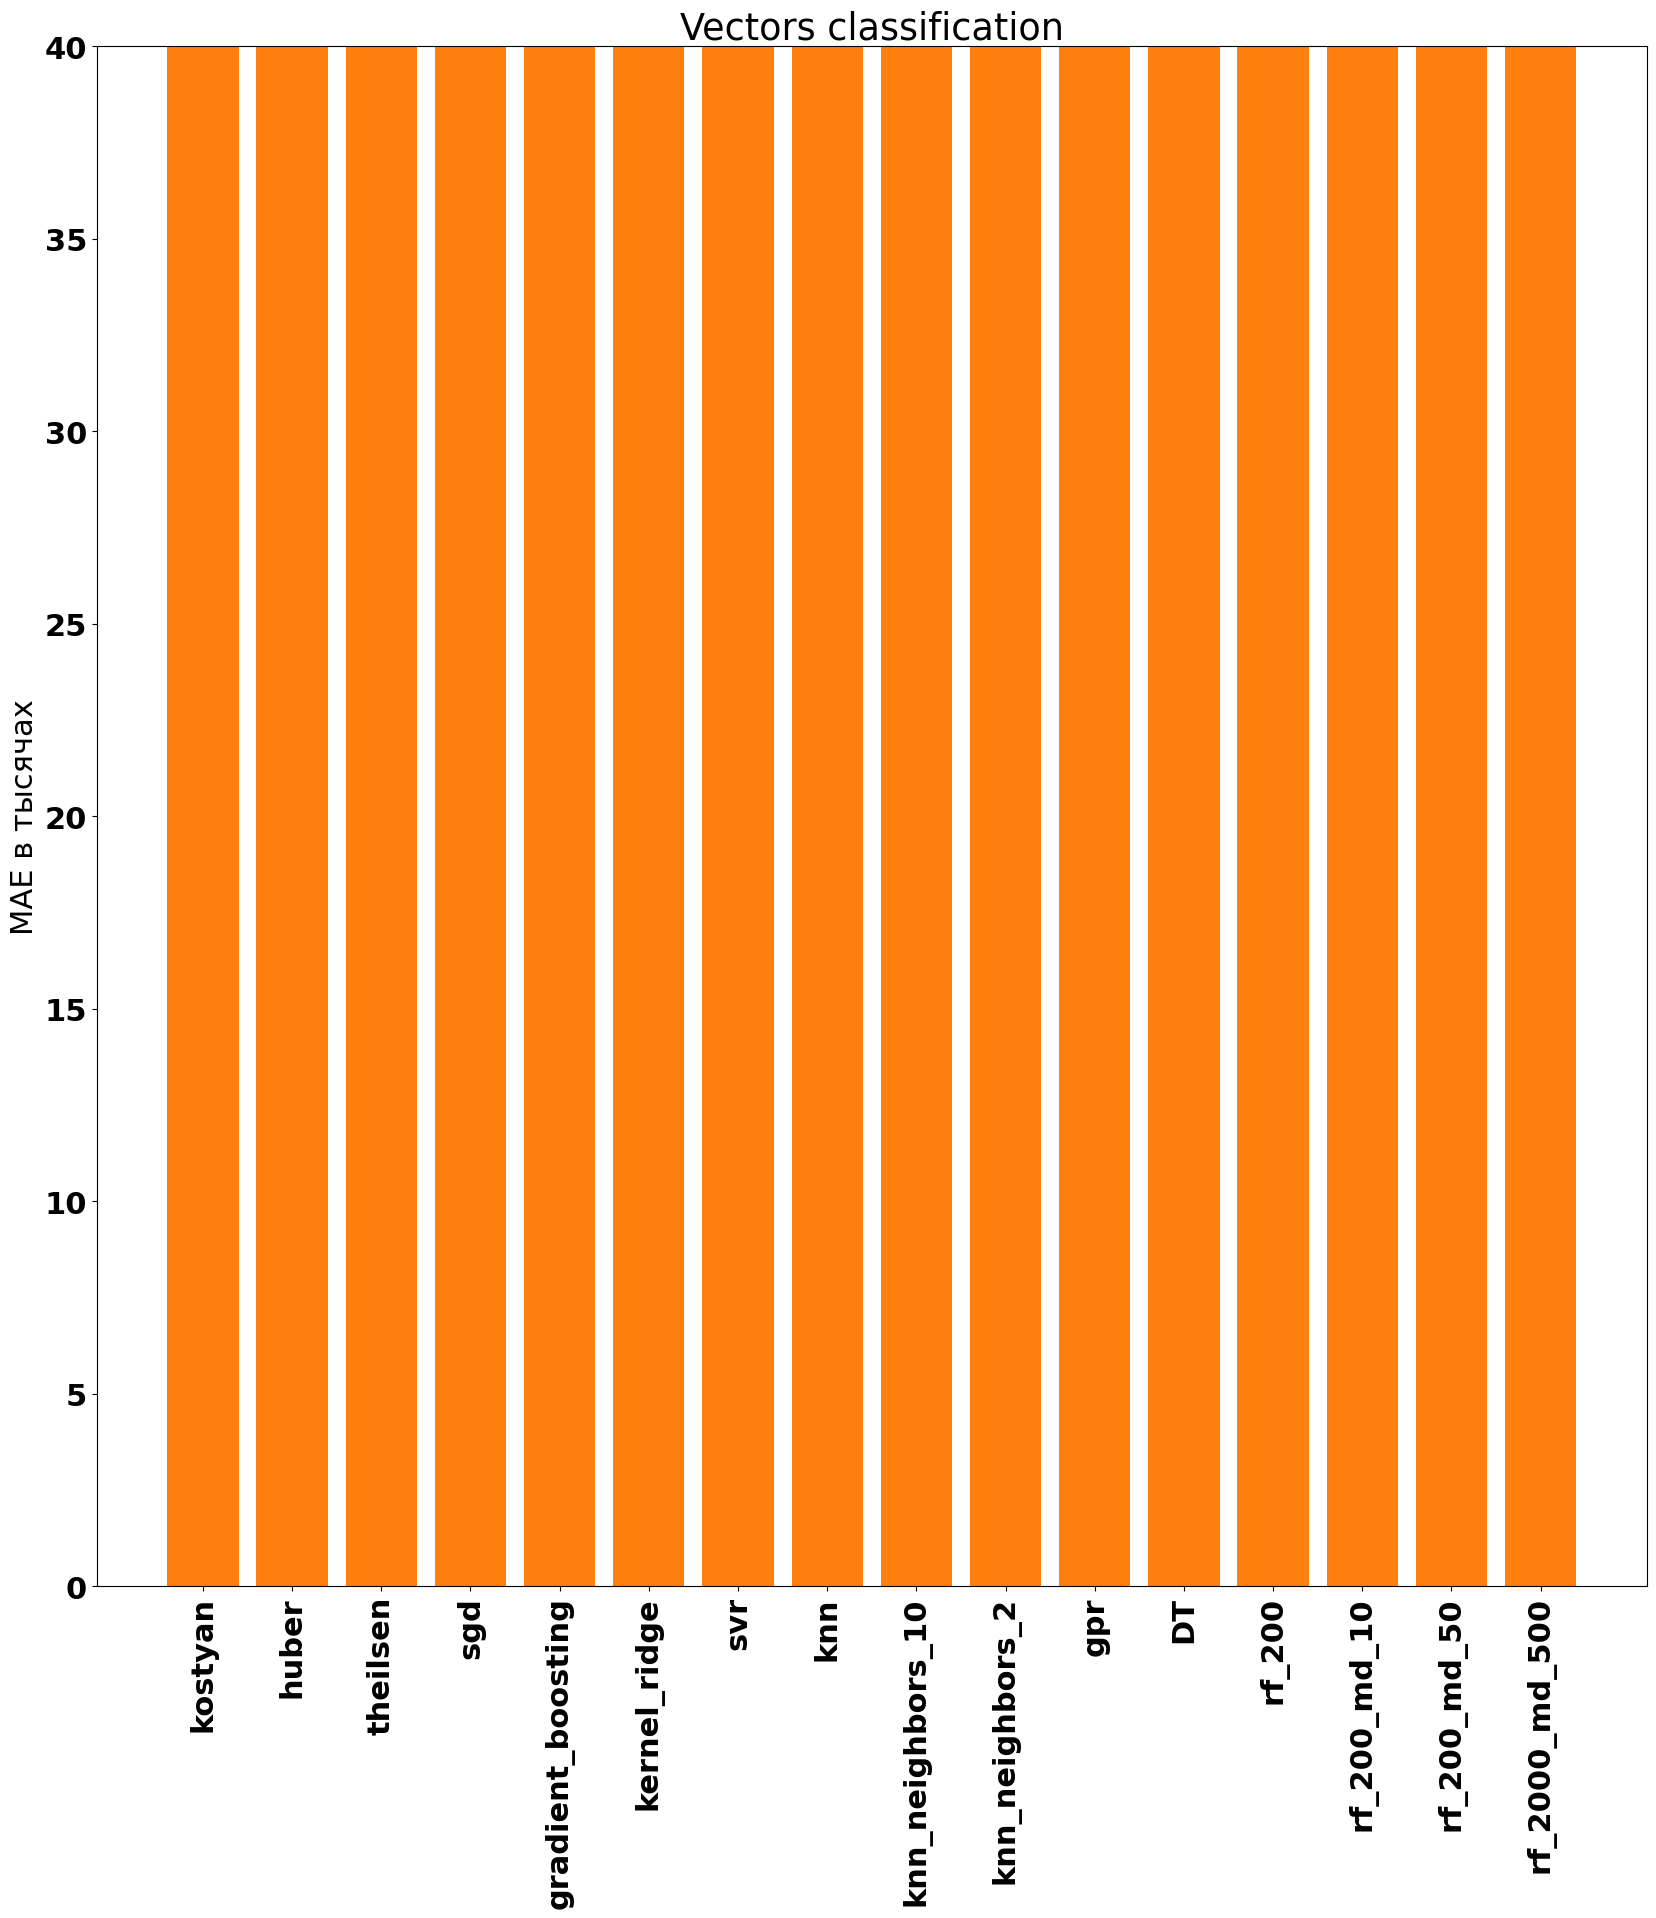

In [274]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.bar(names, [x / 1000 for x in mae_values])
ax.bar(names, [x / 1000 for x in component_mae_values])
ax.set(ylabel='MAE в тысячах', title='Vectors classification', ylim=(0, 40))
plt.rcParams['figure.figsize'] = [20, 20]
plt.xticks(rotation = 90)

fig.savefig("result.png")

20099.979041414877
15034.037243023713


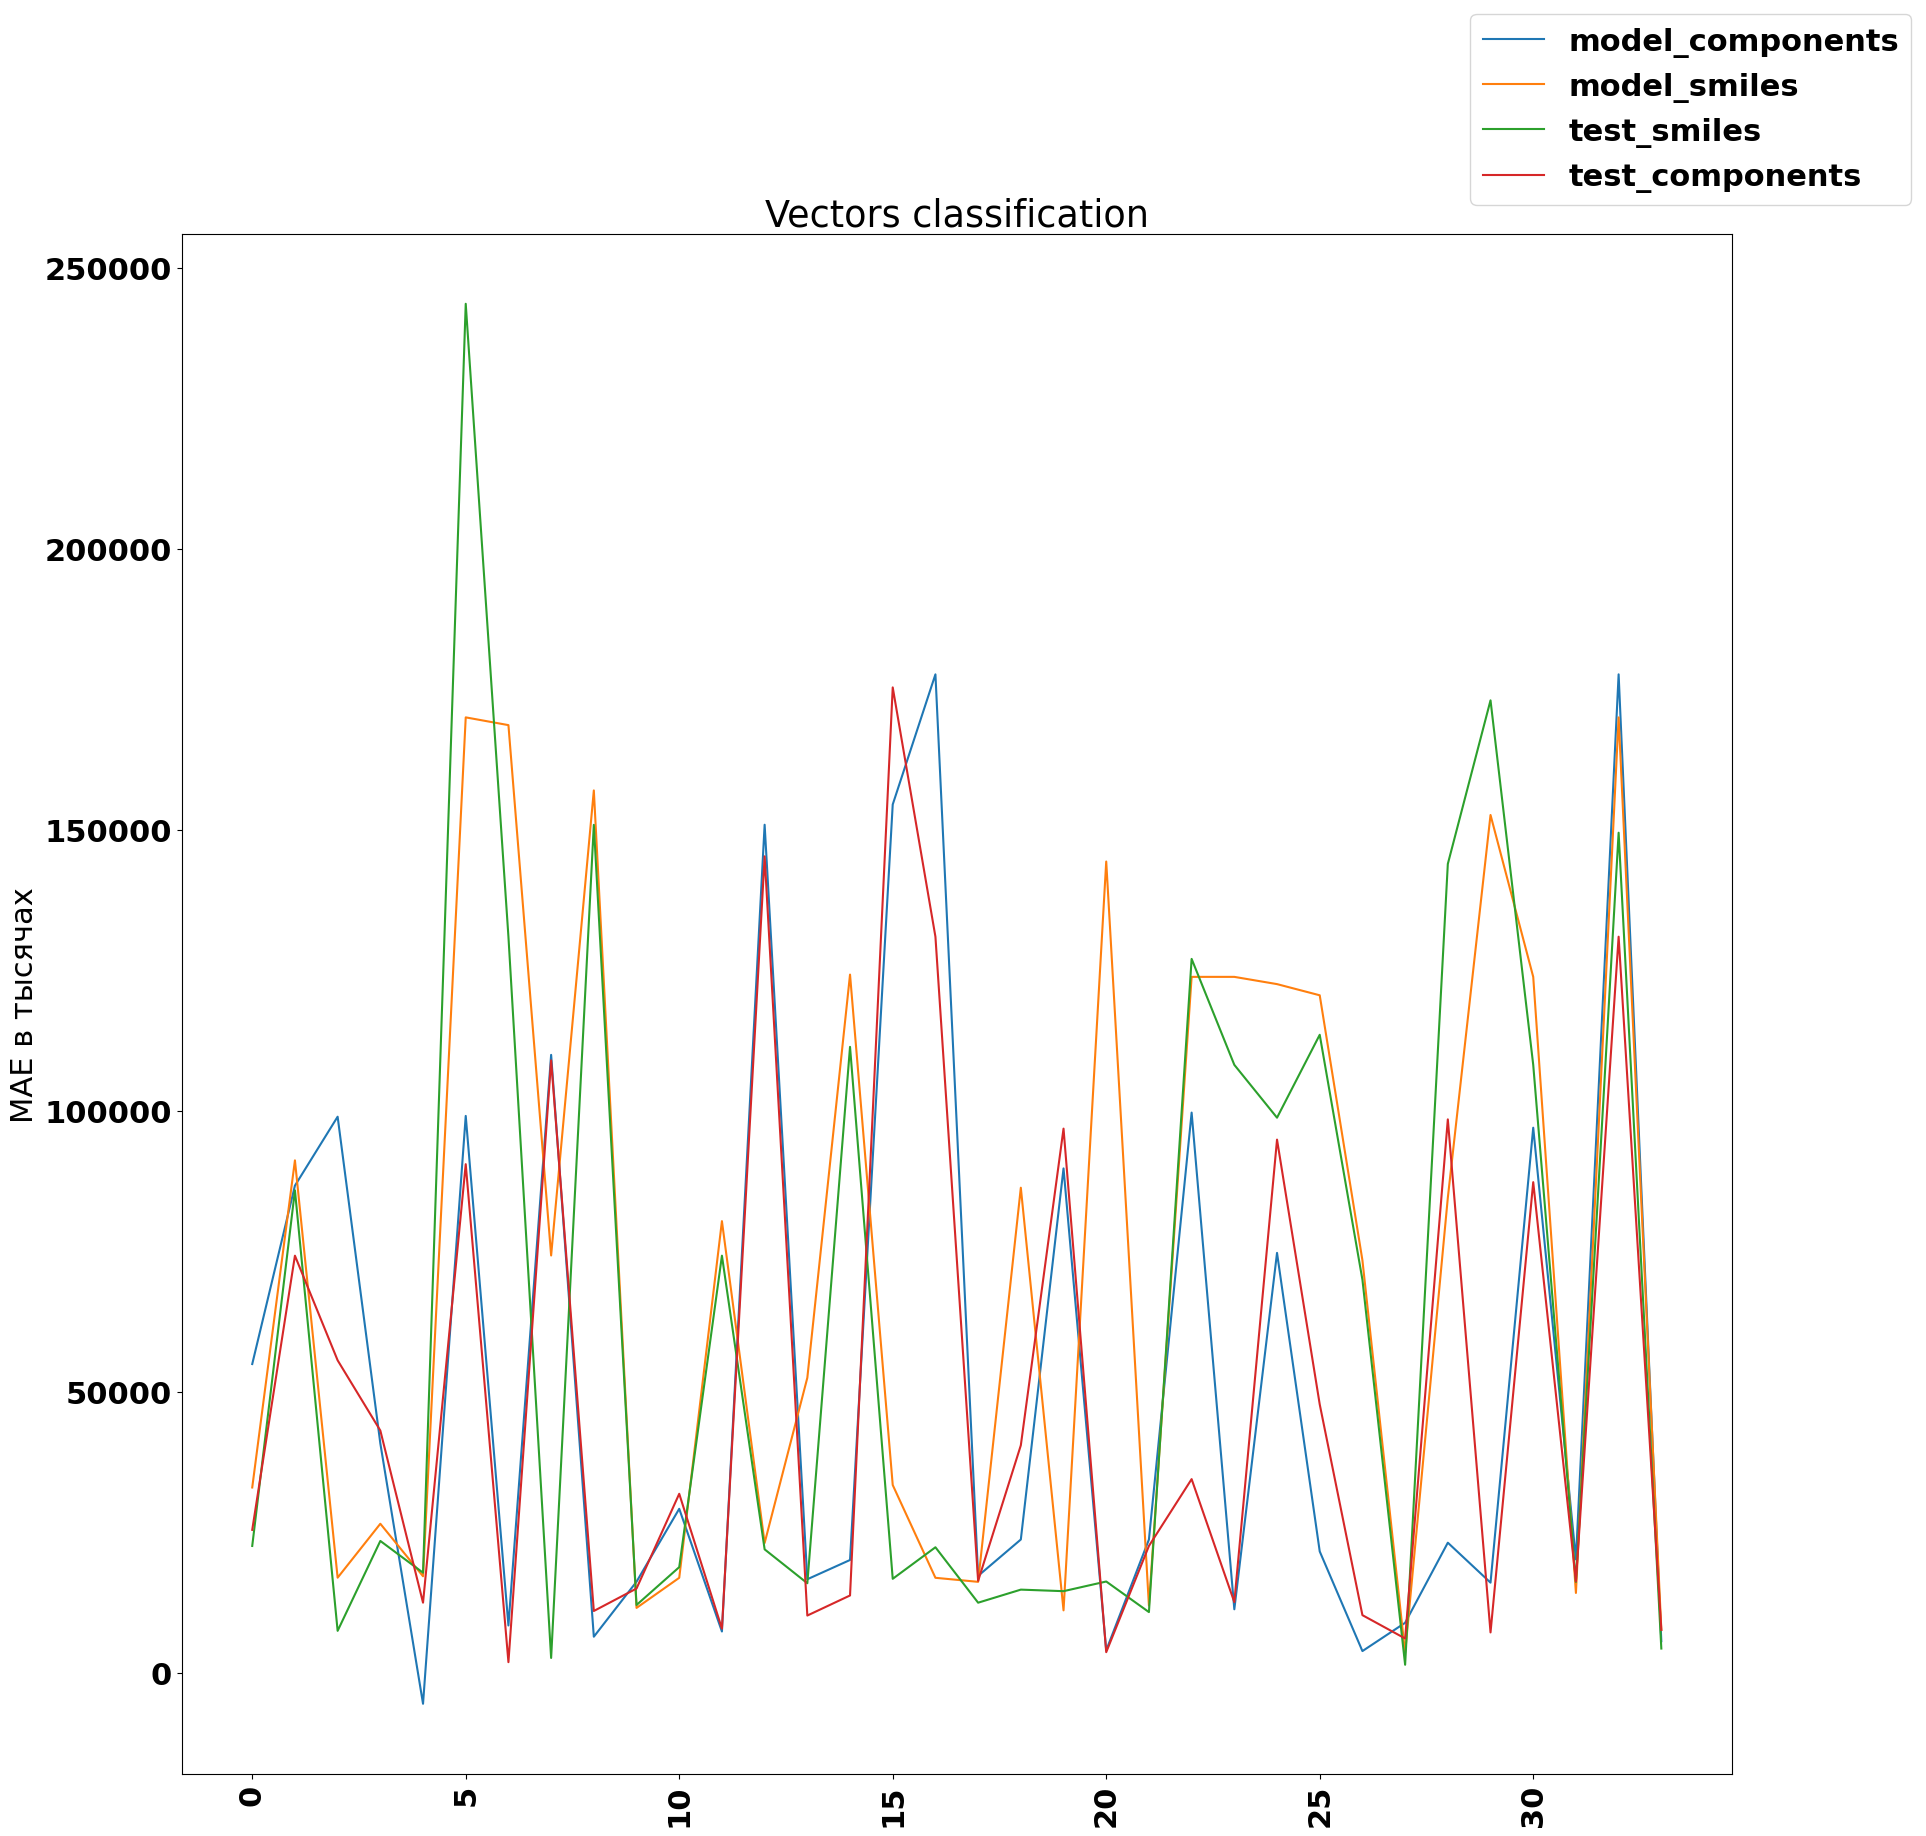

In [289]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

clf = gradient_boosting
component_clf = component_gradient_boosting

fig, ax = plt.subplots()

ax.plot(component_clf.predict(component_x_test), label="model_components")
ax.plot(clf.predict(x_test), label="model_smiles")
ax.plot(y_test, label="test_smiles")
ax.plot(component_y_test, label="test_components")

ax.set(ylabel='MAE в тысячах', title='Vectors classification')
plt.rcParams['figure.figsize'] = [20, 20]

plt.xticks(rotation = 90)
print(mean_absolute_error(y_test, clf.predict(x_test)))
print(mean_absolute_error(component_y_test, component_clf.predict(component_x_test)))

fig.legend()

In [318]:
X_data_concated = []

for index in range(len(X_data_smiles)):
    buffer = []
    buffer.extend(X_data_smiles[index])
    buffer.extend(X_data_components[index])
    X_data_concated.append(np.array(buffer))

X_data_concated = np.array(X_data_concated)
np.shape(X_data_concated)

from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data_concated, Y_data_concated, test_size=0.001)

rf_regressor = RandomForestRegressor(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
gb_regressor = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, min_samples_leaf=4, min_samples_split=5, n_estimators=100)

voting_regressor = VotingRegressor([('rf', rf_regressor), ('gb', gb_regressor)], weights=[1, 2.4])

voting_regressor.fit(x_train, y_train)

VotingRegressor(estimators=[('rf', RandomForestRegressor(min_samples_leaf=2)),
                            ('gb',
                             GradientBoostingRegressor(max_depth=7,
                                                       min_samples_leaf=4,
                                                       min_samples_split=5))],
                weights=[1, 2.4])

3637.283393319505


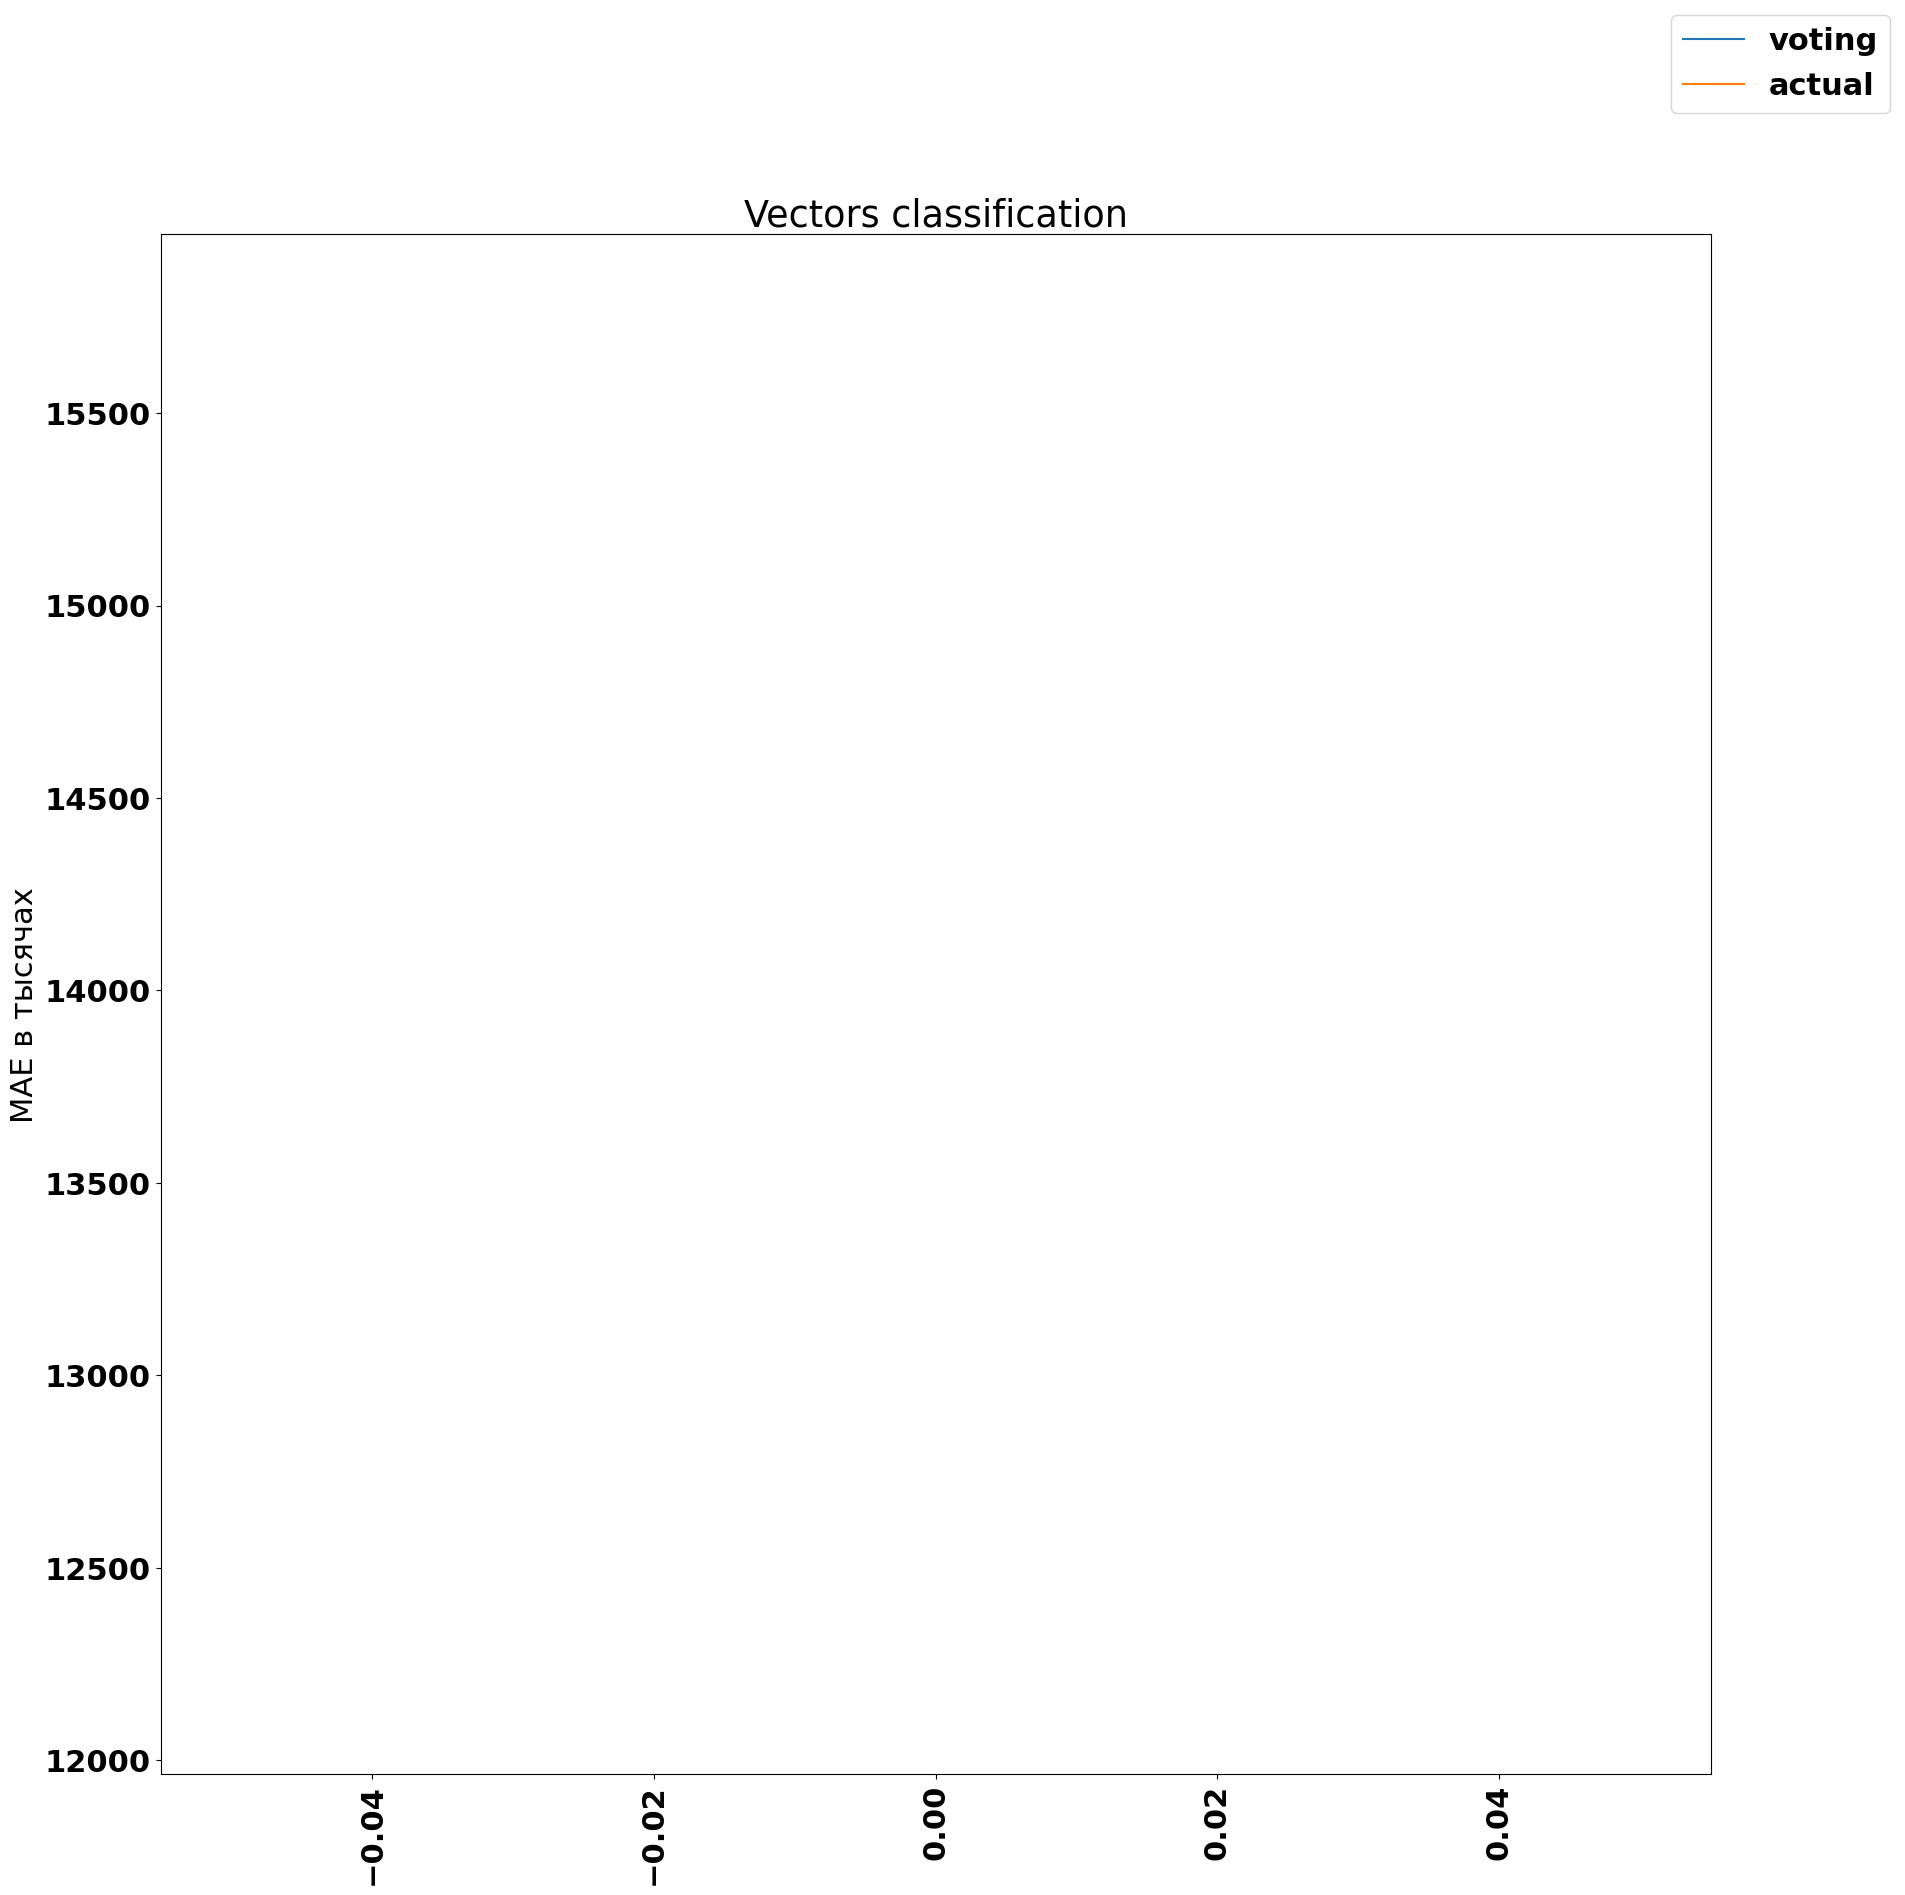

In [319]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

clf = voting_regressor

fig, ax = plt.subplots()

ax.plot(clf.predict(x_test), label="voting")
ax.plot(y_test, label="actual")

ax.set(ylabel='MAE в тысячах', title='Vectors classification')
plt.rcParams['figure.figsize'] = [20, 20]

plt.xticks(rotation = 90)
print(mean_absolute_error(y_test, clf.predict(x_test)))

fig.legend()

### Сабмит

In [308]:
path_to_test_data = Path().cwd().joinpath("test_set_public.csv")

test_df = pd.read_csv(path_to_test_data.__str__())
test_df

workdata = test_df.drop_duplicates()
workdata_oil_ids = workdata["blend_id"].drop_duplicates().to_list()
workdata_oil_ids

test_set = test_set.drop_duplicates(subset=['blend_id'])
test_set

,blend_id,smiles,oil_property_param_value,mixed_smiles
0,d272c9a6-3332-11ed-9685-005056921581,CCC(C)CCCC,NaN,"[1.1527387, 1.2822491, 0.28752342, -1.5620178,..."
4,dea007ac-a065-11ed-9f24-005056921581,CCCC(C)CCC,NaN,"[2.0656943, 1.8718336, 0.8425199, -1.7052934, ..."
6,14efbc8a-9090-11ec-83a1-005056921581,CCC(C)CCCC,NaN,"[1.358824, 1.001291, 0.57717294, -1.0759499, 0..."
10,e48772c8-4e07-11ed-9a6d-005056921581,CCCCC,NaN,"[1.28359, 1.7042809, -0.0103594065, -1.9260083..."
14,72b7aafa-d791-11ed-8145-005056921581,CCCC(C)CCC,NaN,"[2.0656943, 1.8718336, 0.8425199, -1.7052934, ..."
...,...,...,...,...
517,994a200e-853c-11ee-9d2f-005056921581,CCCC(C)CCC,NaN,"[1.2974533, 1.5395757, 0.22797106, -1.7114557,..."
520,eb25ecae-7886-11ee-9d5b-005056921581,CCCCC(C)C,NaN,"[1.2735108, 0.77863055, 0.3072265, -1.1035861,..."
523,e63f290a-fe22-11ed-8421-005056921581,CCCC(C)CCC,NaN,"[1.5826519, 1.3503294, 0.7050677, -1.3216245, ..."
528,f7ff118c-eb17-11ed-9974-005056921581,CCCCCC,NaN,"[1.0039717, 0.707343, -0.226435, -1.3468415, 0..."


In [309]:
def extractKnowlegeFromOilDf(oil_df):
    oil_knowledge = copy.deepcopy(knowledge)
    properties_data = list(set(oil_df["component_property_param_title"].to_list()))

    for item in properties_data:
        value = oil_df.loc[oil_df["component_property_param_title"] == item]["component_property_param_value"].sum()
        if item in total_component_properties:
            oil_knowledge[f"{item}"] = value
        else:
            print("Unknown property")
    return oil_knowledge

X_test_components = []
X_test_smiles = []
Ids = []
for oil in list(set(workdata["blend_id"].to_list())):
    oil_df = workdata.loc[workdata["blend_id"] == oil]
    current_knowledge = extractKnowlegeFromOilDf(oil_df)
    vector = np.array(list(current_knowledge.values()))
    Ids.append(oil)
    X_test_components.append(vector)
    if oil not in test_set["blend_id"].to_list():
        print(f"Zeros for blend id {oil} FOR TRAIN ONLY")
        X_test_smiles.append(np.zeros(len(test_set["mixed_smiles"][0])))
    else:
        X_test_smiles.append(test_set.loc[test_set["blend_id"] == oil]["mixed_smiles"].values[0])
        

Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown property
Unknown proper

In [310]:
X_data_concated = []

for index in range(len(X_test_smiles)):
    buffer = []
    buffer.extend(np.float64(X_test_smiles[index]))
    buffer.extend(np.float64(X_test_components[index]))
    X_data_concated.append(np.array(buffer))

In [311]:
np.shape(X_data_concated)

(138, 831)

In [312]:
voting_regressor.predict(X_data_concated)

array([120473.57911525,  75005.49211901,  16013.91784296,  36299.26337253,
        78955.64853302,  39415.81944691,  95337.08875635,  19378.82395079,
        69870.5250305 ,  39088.28404332,  29385.75060569, 102263.37912062,
        68351.97781748,  66891.46289081, 126464.5417749 , 126464.5417749 ,
       199356.4230296 , 144323.28678167, 218880.45711788, 126464.5417749 ,
       129939.58183069,  65110.91228493,  44360.94461747,  67315.46551157,
       157875.03390893,  54484.25210548,  64988.41742357,  84408.55550471,
       134418.18139446,  30488.12010958,  21395.71823831,  62094.92987223,
        72369.28780623,  49422.68896   ,  49345.41276373, 199356.4230296 ,
        19814.51760854, 124204.89469172,  66922.49083435, 126464.5417749 ,
        91809.37561481,  65110.91228493,  14295.55888272, 275565.36485568,
        33661.33579803,  19372.16744157,  97230.50456534,  14295.55888272,
        46315.5177288 , 122304.85800766,  48661.57548264,  72369.28780623,
        33964.23528001,  

In [314]:
best_predict = list(voting_regressor.predict(X_data_concated))

In [317]:
submit = pd.DataFrame(Ids, columns=["blend_id"])

submit["result"] = best_predict

submit.to_csv("15th_voting_gbr_1_24_components_exctract_upgrade.csv", encoding="utf-8", index=False)

submit

,blend_id,result
0,f1e8135c-6d8a-11ee-889d-005056921581,120473.579115
1,29f3c336-b64d-11ed-84cd-005056921581,75005.492119
2,69cbd8f0-90db-11ed-8e59-005056921581,16013.917843
3,b518b3a2-b82a-11ed-994d-005056921581,36299.263373
4,d967cfcc-a8e5-11ec-9d4e-005056921581,78955.648533
...,...,...
133,b14651e0-e272-11ed-8477-005056921581,57723.510345
134,075e2d8a-09c1-11ee-8f75-005056921581,57802.991162
135,69ad809c-9410-11ee-8abf-005056921581,34035.701789
136,27c81e04-56bc-11ed-9f98-005056921581,41404.253684
